In [1]:
!wget -qq 'https://github.com/lukyfox/Datafiles/raw/master/digits/digits.zip'  
!unzip -qq '/content/digits.zip'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

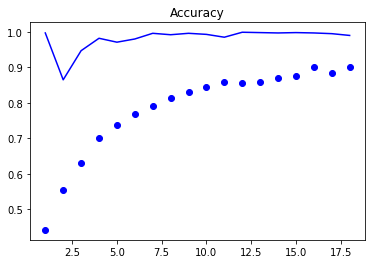

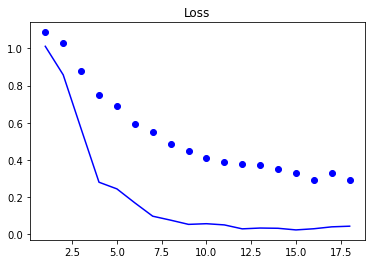

<Figure size 432x288 with 0 Axes>

In [2]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend

from matplotlib import pyplot as plt
import pandas as pd

# reset all states
backend.clear_session()

#image_shape = (330, 330, 3)
# testovani na rozpoznavani greyscale cislic (obdoba mnist, jen se skutecnymi pictures),
# tomu odpovidaji zakomentovane casti kodu
image_shape = (28, 28, 1)

# 1. definice modelu
# Sequential je vstupni vrstva
model = Sequential()
# pridani stohu konvolucnich vrstev pro extrakci features (32 je pocet vrstev/filtru),
# cim vetsi obrazova data, tim vice konvolucnich vrstev ve stohu. Pro muj "mnist" 
# zakomentovat posledni 128-ckovou vrstvu i s poolingem a dostanu se pres 84% presnost 
# (s overfittingem na pod 2%), u pictures kapslovky jsem na 76-80% (s overfittingem pod 1%).
# Pokud necham 128-ckovou vrstvu i pro mnist, jsem v 5-10% overfittingu po celou dobu validace 
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
#model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
#model.add(MaxPooling2D(2,2))

# Flatten pro reshaping na 1D tenzor (nutne pro predani do Dense vrstvy, ktera prijima 1D) 
model.add(Flatten())
# Dropout pro nahodne vynechani neuronu v siti - dalsi zabraneni preuceni site 
# (celkove zajisteno pomoci Dropout+random transformace+callback)
model.add(Dropout(0.5))
# Dense je huste propojena sit
model.add(Dense(256, activation='relu'))
# vystupni Dense vrstva se tremi hladinami (vystupy) pro 3 klasifikacni kategorie
model.add(Dense(3, activation='softmax'))

# vypis vrstev modelu
model.summary()
# optimalizator Adam je v CNN prvni volbou kvuli vysoke presnosti, learning_rate otestovan od default 0.01 do 10^-6,
# nastaveni 0.0001 dava neljepsi vysledky
opt = Adam(learning_rate=0.0001)
# sestaveni modelu
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# 2. nacteni dat
# ImageDataGenerator je tridou provadejici random transformace s obrazkem pro konvoluci, tzv. augmentaci. 
# Cilem je zvyseni poctu trenovacich dat, transformace zlepsuji schopnost vyhledavani features - train faze ma
# k dispozici vice vzoru v nahodne transformovanych obrazcih, pritom ale nejde o vzory nove (transformace 
# vzory nevytvareji, jen zlepsuji jejich rozpoznani) 
train_imagedatagen = ImageDataGenerator(rotation_range=45,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              fill_mode='nearest', rescale=1./255)
# validacni data generator nemuze byt augmentovan, nejde uz o uceni features, ale o jejich rozpoznavani
validation_imagedatagen = ImageDataGenerator(rescale=1./255)


# batch size je velikost davky zpracovane v jednom pruchodu, tzn. pocet obrazku nebo vrstev jednom prikladu, 
# jedna se o hyperparametr (tj. ovlivnuje vysledky modelu, ale neni zavisly na datech) 
# (TODO: vyhledat jestli batch_size 3 pro 3 kanalovy RGB obrazek = 1 nebo 3 obrazky a jaky je efekt ruzne velikosti batch_size
# https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e)
batch_size = 20
# data jsou rozdelena v adresarich train a validation, podadresare jsou jedntlive tridy,
# flow_from_directory automaticky vytvori kategorie z nazvu adresaru a zarazeni samplu
train_path = '/content/digits/train'
#train_path = '/content/drive/MyDrive/Datafiles/it4n/_splitted/train'
train_imageflow = train_imagedatagen.flow_from_directory(train_path,
                                               color_mode= 'grayscale', #'rgb'
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               target_size = image_shape[:2],)

validation_path = '/content/digits/validation' 
#validation_path = '/content/drive/MyDrive/Datafiles/it4n/_splitted/validation'
# shuffle je False, aby se pri opakovanem behu samply nacitaly v nenahodnem poradi
validation_imageflow = validation_imagedatagen.flow_from_directory(validation_path,
                                               target_size = image_shape[:2],
                                               color_mode='grayscale', #'rgb'
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)


# epochs udavaji pocet cyklu behu site, tj. opakovani, ve kterych se sit bude sazit ucit a (optimalne) snizovat ztratu nalezanim 
# a vyhodnocovanim dalsich a dalsich features, tim se ale zvysuje pravdepodobnost overfittingu a navic sit muze bezet zbytecne 
# dlouho (napr. ve 3. epose dosahle nejlepsiho vysledku, ale pri zadani 20 epoch si musi stejne odmakat dalsich 17). Oboje muze 
# pomoci resit callback, napr. EarlyStopping (callbacku muze byt vic)  
epochs = 20
# EarlyStopping vyhodnoti parametr v monitoring a pokud se pri behu site mezi epochami nezmeni s periodou < patience, 
# beh ukonci i kdyby jeste zbyvaly dalsi neprovedene epochy
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/  
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 3. sestaveni modelu a spusteni uceni,
# steps_per_epochs udava pocet transformaci v ramci epochy, validation_steps je pocet validaci (bere se asi prumerna hodnota trefy), 
# pricemz validace neobsahuje transformaci (tipuju, ze by nebyla k nicemu dobra :) 
history = model.fit(
    train_imageflow,
    epochs=epochs,
    validation_data=validation_imageflow,
    callbacks=[early_stopping],
    steps_per_epoch=100,
    validation_steps=50
    )

# 4. zobrazeni vysledku
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
xepochs = range(1, len(accuracy)+1)

# sestaveni grafu, 'bo' jsou blue dots, 'b' je blue line
plt.plot(xepochs, accuracy, 'bo', label='Training accuracy')
plt.plot(xepochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.figure()

plt.plot(xepochs, loss, 'bo', label='Training loss')
plt.plot(xepochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.figure()

# vystupy v history.history ulozim jako pandas dataframe
df = pd.DataFrame(history.history)
print(df)

# vytisteni jednoho obrazku (jen test)
#for data, label in validation_imageflow:
#  print('data batch shape:', data.shape)
#  plt.imshow(data[0])
#  plt.title(str(label[0]))
#  print('label batch shape:', label.shape)
#  break

# spusteni vykresleni
plt.show()